# 1. zadatak: Učitavanje podataka (10%)



In [ ]:
from torch.utils.data import Dataset
from collections import defaultdict
from random import choice
import torchvision


class MNISTMetricDataset(Dataset):
    def __init__(self, root="/tmp/mnist/", split='train', remove_class=None):
        super().__init__()
        assert split in ['train', 'test', 'traineval']
        self.root = root
        self.split = split
        mnist_ds = torchvision.datasets.MNIST(self.root, train='train' in split, download=True)
        self.images, self.targets = mnist_ds.data.float() / 255., mnist_ds.targets
        self.classes = list(range(10))

        if remove_class is not None:
            new_images = []
            new_targets = []
            for image, target in zip(self.images, self.targets):
              if target != remove_class:
                new_images.append(image)
                new_targets.append(target)
            self.images, self.targets = new_images, new_targets

        self.target2indices = defaultdict(list)
        for i in range(len(self.images)):
            self.target2indices[self.targets[i].item()] += [i]

    def _sample_negative(self, index):
        cls = self.targets[index].item()
        candidate = choice(range(len(self.images)))
        while cls == self.targets[candidate].item():
          candidate = choice(range(len(self.images)))
        return candidate

    def _sample_positive(self, index):
        cls = self.targets[index].item()
        candidate = choice(range(len(self.images)))
        while cls != self.targets[candidate].item():
          candidate = choice(range(len(self.images)))
        return candidate

    def __getitem__(self, index):
        anchor = self.images[index].unsqueeze(0)
        target_id = self.targets[index].item()
        if self.split in ['traineval', 'val', 'test']:
            return anchor, target_id
        else:
            positive = self._sample_positive(index)
            negative = self._sample_negative(index)
            positive = self.images[positive]
            negative = self.images[negative]
            return anchor, positive.unsqueeze(0), negative.unsqueeze(0), target_id

    def __len__(self):
        return len(self.images)

# 2. zadatak: Definicija modela za metričko ugrađivanje (40%)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from numpy import linalg as LA

class _BNReluConv(nn.Sequential):
    def __init__(self, num_maps_in, num_maps_out, k=3, bias=True):
        super(_BNReluConv, self).__init__()
        self.append(nn.ReLU())
        self.append(nn.Conv2d(num_maps_in, num_maps_out, k, bias=True))

class SimpleMetricEmbedding(nn.Module):
    def __init__(self, input_channels, emb_size=32):
        super().__init__()
        self.emb_size = emb_size

        self.bnreluconv1 = _BNReluConv(1, emb_size)
        self.bnreluconv2 = _BNReluConv(32, emb_size)
        self.bnreluconv3 = _BNReluConv(32, emb_size)
        self.maxpool = nn.MaxPool2d(stride=2, kernel_size=3)
        self.avgpool = nn.AvgPool2d(stride=3, kernel_size=2)

    def get_features(self, img):
        x = self.bnreluconv1(img)
        x = self.maxpool(x)

        x = self.bnreluconv2(x)
        x = self.maxpool(x)

        x = self.bnreluconv3(x)
        x = self.avgpool(x)

        return x.reshape((img.size(dim=0), emb_size))

    def loss(self, anchor, positive, negative):
        a_x = self.get_features(anchor)
        p_x = self.get_features(positive)
        n_x = self.get_features(negative)

        triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
        return triplet_loss(a_x, p_x, n_x)

# 3. zadatak: Učenje i vrednovanje (40%)

In [ ]:
import numpy as np
import torch
from collections import defaultdict
PRINT_LOSS_N = 100


def train(model, optimizer, loader, device='cuda'):
    losses = []
    model.train()
    for i, data in enumerate(loader):
        anchor, positive, negative, _ = data
        optimizer.zero_grad()
        loss = model.loss(anchor.to(device), positive.to(device), negative.to(device))
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().item())
        if i % PRINT_LOSS_N == 0:
            print(f"Iter: {i}, Mean Loss: {np.mean(losses):.3f}")
    return np.mean(losses)


def compute_representations(model, loader, identities_count, emb_size=32, device='cuda'):
    model.eval()
    representations = defaultdict(list)
    for i, data in enumerate(loader):
        anchor, id = data[0], data[-1]
        with torch.no_grad():
            repr = model.get_features(anchor.to(device))
            repr = repr.view(-1, emb_size)
        for i in range(id.shape[0]):
            representations[id[i].item()].append(repr[i])
    averaged_repr = torch.zeros(identities_count, emb_size).to(device)
    for k, items in representations.items():
        r = torch.cat([v.unsqueeze(0) for v in items], 0).mean(0)
        averaged_repr[k] = r / torch.linalg.vector_norm(r)
    return averaged_repr


def make_predictions(representations, r):
    return ((representations - r)**2).sum(1) # predictions based on L2 distance


def evaluate(model, repr, loader, device):
    model.eval()
    total = 0
    correct = 0
    for i, data in enumerate(loader):
        anchor, id = data
        id = id.to(device)
        with torch.no_grad():
            r = model.get_features(anchor.to(device))
            r = r / torch.linalg.vector_norm(r)
        pred = make_predictions(repr, r)
        top1 = pred.min(0)[1]
        correct += top1.eq(id).sum().item()
        total += 1
    return correct/total

In [ ]:
import time
import datetime
import torch.optim
from torch.utils.data import DataLoader

EVAL_ON_TEST = True
EVAL_ON_TRAIN = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"= Using device {device}")

mnist_download_root = "./mnist/"
ds_train = MNISTMetricDataset(mnist_download_root, split='train')
ds_test = MNISTMetricDataset(mnist_download_root, split='test')
ds_traineval = MNISTMetricDataset(mnist_download_root, split='traineval')

num_classes = 10

print(f"> Loaded {len(ds_train)} training images!")
print(f"> Loaded {len(ds_test)} validation images!")

train_loader = DataLoader(
    ds_train,
    batch_size=64,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
    drop_last=True
)

test_loader = DataLoader(
    ds_test,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    num_workers=1
)

traineval_loader = DataLoader(
    ds_traineval,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    num_workers=1
)

emb_size = 32
model = SimpleMetricEmbedding(1, emb_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 3
for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")
    t0 = time.time_ns()
    train_loss = train(model, optimizer, train_loader, device)
    print(f"Mean Loss in Epoch {epoch+1}: {train_loss:.3f}")
    if EVAL_ON_TEST or EVAL_ON_TRAIN:
        print("Computing mean representations for evaluation...")
        representations = compute_representations(model, train_loader, num_classes, emb_size, device)
    if EVAL_ON_TRAIN:
        print("Evaluating on training set...")
        acc1 = evaluate(model, representations, traineval_loader, device)
        print(f"Epoch {epoch+1}: Train Top1 Acc: {round(acc1 * 100, 2)}%")
    if EVAL_ON_TEST:
        print("Evaluating on test set...")
        acc1 = evaluate(model, representations, test_loader, device)
        print(f"Epoch {epoch+1}: Test Accuracy: {acc1 * 100:.2f}%")
    t1 = time.time_ns()
    print(f"Epoch time (sec): {(t1-t0)/10**9:.1f}")


filename = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
print(f'Saving model to: {filename}.model')
model.eval()
model = model.to('cpu')
torch.save(model.state_dict(), f'{filename}.model')


= Using device cuda


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

> Loaded 60000 training images!
> Loaded 10000 validation images!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1
Iter: 0, Mean Loss: 0.976
Iter: 100, Mean Loss: 0.362
Iter: 200, Mean Loss: 0.248
Iter: 300, Mean Loss: 0.199
Iter: 400, Mean Loss: 0.169
Iter: 500, Mean Loss: 0.147
Iter: 600, Mean Loss: 0.132
Iter: 700, Mean Loss: 0.120
Iter: 800, Mean Loss: 0.111
Iter: 900, Mean Loss: 0.104
Mean Loss in Epoch 1: 0.102
Computing mean representations for evaluation...
Evaluating on test set...
Epoch 1: Test Accuracy: 96.19%
Epoch time (sec): 43.5
Epoch: 2
Iter: 0, Mean Loss: 0.058
Iter: 100, Mean Loss: 0.037
Iter: 200, Mean Loss: 0.038
Iter: 300, Mean Loss: 0.037
Iter: 400, Mean Loss: 0.036
Iter: 500, Mean Loss: 0.036
Iter: 600, Mean Loss: 0.035
Iter: 700, Mean Loss: 0.035
Iter: 800, Mean Loss: 0.035
Iter: 900, Mean Loss: 0.034
Mean Loss in Epoch 2: 0.034
Computing mean representations for evaluation...
Evaluating on test set...
Epoch 2: Test Accuracy: 97.35%
Epoch time (sec): 44.1
Epoch: 3
Iter: 0, Mean Loss: 0.034
Iter: 100, Mean Loss: 0.032
Iter: 200, Mean Loss: 0.030
Iter: 300, Mean Loss:

## Klasifikacija na temelju udaljenosti u prostoru slike

In [ ]:
class IdentityModel(nn.Module):
    def __init__(self):
        super(IdentityModel, self).__init__()

    def get_features(self, img):
        return img.flatten()

In [ ]:
representations = compute_representations(IdentityModel(), traineval_loader, num_classes, 784, device)
acc = evaluate(IdentityModel(), representations, traineval_loader, device)
print(f'Eval L2 Accuracy: {acc * 100:.2f}%')


Eval L2 Accuracy: 81.36%


## Remove class 0

In [ ]:
import time
import datetime
import torch.optim
from torch.utils.data import DataLoader

EVAL_ON_TEST = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"= Using device {device}")

mnist_download_root = "./mnist/"
ds_train = MNISTMetricDataset(mnist_download_root, split='train', remove_class=0)
ds_test = MNISTMetricDataset(mnist_download_root, split='test')

num_classes = 10

print(f"> Loaded {len(ds_train)} training images!")
print(f"> Loaded {len(ds_test)} validation images!")

train_loader = DataLoader(
    ds_train,
    batch_size=64,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
    drop_last=True
)

test_loader = DataLoader(
    ds_test,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    num_workers=1
)

emb_size = 32
model = SimpleMetricEmbedding(1, emb_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 3
for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")
    t0 = time.time_ns()
    train_loss = train(model, optimizer, train_loader, device)
    print(f"Mean Loss in Epoch {epoch+1}: {train_loss:.3f}")
    if EVAL_ON_TEST or EVAL_ON_TRAIN:
        print("Computing mean representations for evaluation...")
        representations = compute_representations(model, train_loader, num_classes, emb_size, device)
    if EVAL_ON_TEST:
        print("Evaluating on test set...")
        acc1 = evaluate(model, representations, test_loader, device)
        print(f"Epoch {epoch+1}: Test Accuracy: {acc1 * 100:.2f}%")
    t1 = time.time_ns()
    print(f"Epoch time (sec): {(t1-t0)/10**9:.1f}")



= Using device cuda
> Loaded 54077 training images!
> Loaded 10000 validation images!
Epoch: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iter: 0, Mean Loss: 0.945
Iter: 100, Mean Loss: 0.353
Iter: 200, Mean Loss: 0.233
Iter: 300, Mean Loss: 0.183
Iter: 400, Mean Loss: 0.155
Iter: 500, Mean Loss: 0.135
Iter: 600, Mean Loss: 0.121
Iter: 700, Mean Loss: 0.110
Iter: 800, Mean Loss: 0.101
Mean Loss in Epoch 1: 0.098
Computing mean representations for evaluation...
Evaluating on test set...
Epoch 1: Test Accuracy: 87.11%
Epoch time (sec): 39.0
Epoch: 2
Iter: 0, Mean Loss: 0.033
Iter: 100, Mean Loss: 0.038
Iter: 200, Mean Loss: 0.037
Iter: 300, Mean Loss: 0.037
Iter: 400, Mean Loss: 0.037
Iter: 500, Mean Loss: 0.037
Iter: 600, Mean Loss: 0.036
Iter: 700, Mean Loss: 0.035
Iter: 800, Mean Loss: 0.034
Mean Loss in Epoch 2: 0.034
Computing mean representations for evaluation...
Evaluating on test set...
Epoch 2: Test Accuracy: 87.59%
Epoch time (sec): 39.2
Epoch: 3
Iter: 0, Mean Loss: 0.007
Iter: 100, Mean Loss: 0.026
Iter: 200, Mean Loss: 0.024
Iter: 300, Mean Loss: 0.025
Iter: 400, Mean Loss: 0.025
Iter: 500, Mean Loss: 0.025
It

# 4. zadatak: Vizualizacija podataka (10%)

= Using device cuda
Fitting PCA directly from images...


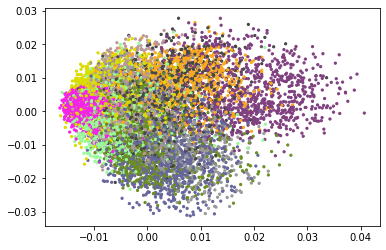

Fitting PCA from feature representation


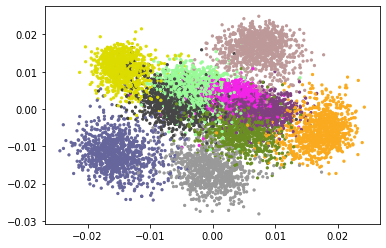

In [ ]:
import numpy as np
import torch

from matplotlib import pyplot as plt


def get_colormap():
    # Cityscapes colormap for first 10 classes
    colormap = np.zeros((10, 3), dtype=np.uint8)
    colormap[0] = [128, 64, 128]
    colormap[1] = [244, 35, 232]
    colormap[2] = [70, 70, 70]
    colormap[3] = [102, 102, 156]
    colormap[4] = [190, 153, 153]
    colormap[5] = [153, 153, 153]
    colormap[6] = [250, 170, 30]
    colormap[7] = [220, 220, 0]
    colormap[8] = [107, 142, 35]
    colormap[9] = [152, 251, 152]
    return colormap


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"= Using device {device}")
emb_size = 32
model = SimpleMetricEmbedding(1, emb_size).to(device)
model.load_state_dict(torch.load('20220601-071830.model'))
model = model.to('cpu')

colormap = get_colormap()
mnist_download_root = "./mnist/"
ds_test = MNISTMetricDataset(mnist_download_root, split='test')
X = ds_test.images
Y = ds_test.targets
print("Fitting PCA directly from images...")
test_img_rep2d = torch.pca_lowrank(ds_test.images.view(-1, 28 * 28), 2)[0]
plt.scatter(test_img_rep2d[:, 0], test_img_rep2d[:, 1], color=colormap[Y[:]] / 255., s=5)
plt.show()
plt.figure()

print("Fitting PCA from feature representation")
with torch.no_grad():
    model.eval()
    test_rep = model.get_features(X.unsqueeze(1))
    test_rep2d = torch.pca_lowrank(test_rep, 2)[0]
    plt.scatter(test_rep2d[:, 0], test_rep2d[:, 1], color=colormap[Y[:]] / 255., s=5)
    plt.show()